## Movie Recommendation System for Turner Classic Movies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

In [96]:
links_df = pd.read_csv('data/ml-25m/ml-25m/links.csv')
movies_df = pd.read_csv('data/ml-25m/ml-25m/movies.csv')
ratings_df = pd.read_csv('data/ml-25m/ml-25m/ratings.csv')
tags_df = pd.read_csv('data/ml-25m/ml-25m/tags.csv')
genome_scores_df = pd.read_csv('data/ml-25m/ml-25m/genome-scores.csv')
genome_tags_df = pd.read_csv('data/ml-25m/ml-25m/genome-tags.csv')

In [97]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [98]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [99]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [100]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [101]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')

In [102]:
movies_df

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [103]:
movies_df['year'].isna().sum()

410

In [104]:
movies_df = movies_df.dropna(subset=['year'])

In [105]:
movies_df['year'].isna().sum()

0

In [106]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62013 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62013 non-null  int64 
 1   title    62013 non-null  object
 2   genres   62013 non-null  object
 3   year     62013 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [107]:
movies_df_old = movies_df.copy()

In [108]:
movies_df_old['year'] = movies_df_old['year'].astype(int)

In [109]:
movies_df_clean = movies_df_old[movies_df_old['year'] <= 1979]

In [110]:
movies_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17007 entries, 109 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  17007 non-null  int64 
 1   title    17007 non-null  object
 2   genres   17007 non-null  object
 3   year     17007 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 597.9+ KB


In [111]:
movies_df_final = movies_df_clean.drop('year', axis=1)

In [112]:
movies_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17007 entries, 109 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  17007 non-null  int64 
 1   title    17007 non-null  object
 2   genres   17007 non-null  object
dtypes: int64(1), object(2)
memory usage: 531.5+ KB


In [113]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [114]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [115]:
ratings_df_clean = ratings_df.drop(columns='timestamp')

In [116]:
ratings_df_clean.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [117]:
ratings_df_final = ratings_df_clean[ratings_df_clean['movieId'].isin(movies_df_final['movieId'])]

In [118]:
ratings_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039809 entries, 4 to 25000031
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 92.8 MB


In [119]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [120]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [121]:
tags_df_clean = tags_df.drop(columns='timestamp')

In [122]:
tags_df_clean.head()

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good


In [123]:
tags_df_clean['tag'].value_counts()['classic']

3456

In [124]:
genome_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [125]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [126]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [127]:
genome_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


EDA Graphs

In [128]:
movies_df_final.reset_index(inplace=True, drop=True)

In [129]:
movies_df_final

,movieId,title,genres
0,111,Taxi Driver (1976),Crime|Drama|Thriller
1,154,Beauty of the Day (Belle de jour) (1967),Drama
2,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",Drama|Musical|Romance
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,390,Faster Pussycat! Kill! Kill! (1965),Action|Crime|Drama
...,...,...,...
17002,209137,The Reward's Yours... The Man's Mine (1969),Western
17003,209139,Rimsky-Korsakov (1953),Drama
17004,209141,And They Lived Happily Ever After (1976),Comedy
17005,209147,The Carpet of Horror (1962),Crime|Horror


In [130]:
ratings_df_final.reset_index(inplace=True, drop=True)

In [131]:
ratings_df_final

,userId,movieId,rating
0,1,899,3.5
1,1,1237,5.0
2,1,1250,4.0
3,1,1260,3.5
4,1,2351,4.5
...,...,...,...
3039804,162541,2080,4.0
3039805,162541,2788,4.5
3039806,162541,2819,3.5
3039807,162541,2947,1.5


In [136]:
movies_and_ratings_df = pd.merge(movies_df_final, ratings_df_final, on='movieId', how='right')

In [137]:
movies_and_ratings_df

,movieId,title,genres,userId,rating
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance,1,3.5
1,899,Singin' in the Rain (1952),Comedy|Musical|Romance,31,4.0
2,899,Singin' in the Rain (1952),Comedy|Musical|Romance,58,5.0
3,899,Singin' in the Rain (1952),Comedy|Musical|Romance,59,3.5
4,899,Singin' in the Rain (1952),Comedy|Musical|Romance,72,5.0
...,...,...,...,...,...
3039804,117644,Dr. Socrates (1935),Crime|Drama|Romance,162047,3.5
3039805,123425,The Last Gangster (1937),Crime|Drama|Thriller,162047,3.0
3039806,131211,Copper Canyon (1950),Action|Western,162047,3.0
3039807,151050,The Burning Court (1962),Drama|Horror|Mystery|Thriller,162047,4.0


Graph most popular movies by number of ratings, average rating

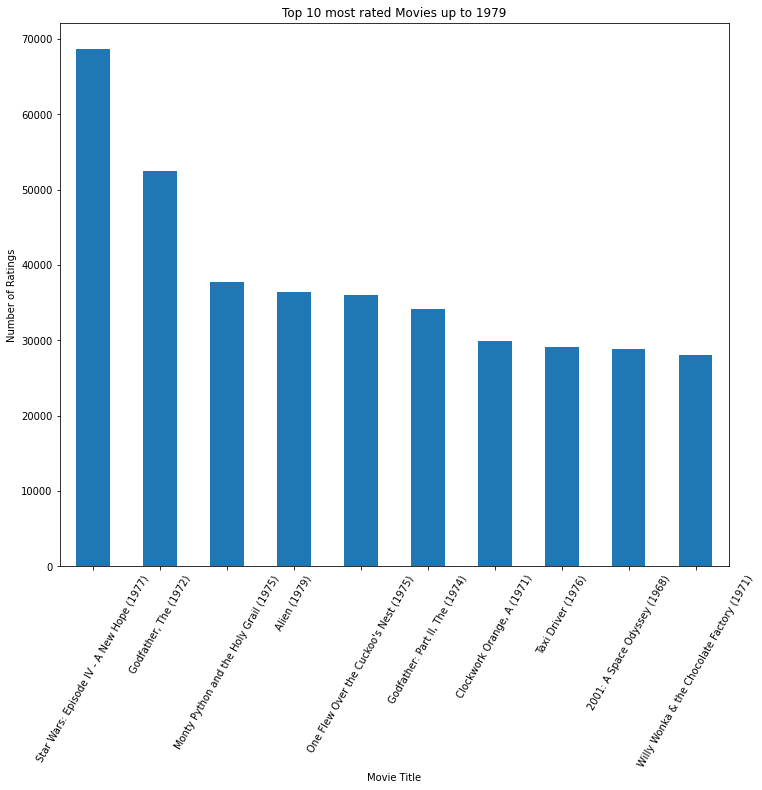

In [162]:
movies_and_ratings_df['title'].value_counts(sort=True).head(10).plot(
    figsize = (12, 10),
    kind = 'bar',
    title = 'Top 10 most rated Movies up to 1979',
    ylabel = 'Number of Ratings',
    xlabel = 'Movie Title',
    );
plt.xticks(rotation=60);

These Movies might have an effect on modeling because of their number of reviews.

<Axes: title={'center': 'Top Ten Highest Rated Movies up to 1979'}, xlabel='title'>

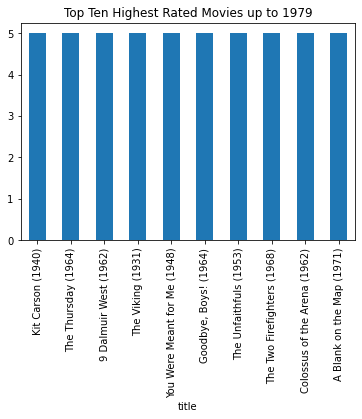

In [164]:
movies_and_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(
    kind='bar',
    title='Top Ten Highest Rated Movies up to 1979',)

Doesn't really say much because these movies might only have 1 5 star rating.

# Modeling

In [132]:
reader = Reader()
data = Dataset.load_from_df(ratings_df_final, reader)

In [133]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  138076 

Number of items:  14908


More efficient to item-item similarity because there are less items than users.

Baseline KNN Model with pearson correlation and item-item similarity.

In [165]:
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':False})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [166]:
print(np.mean(cv_knn_basic['test_rmse']))

0.8420177917310662


Baseline model with no hyperparameter tuning has RMSE of .842

In [134]:
## Gridsearch with SVD
params = {'n_factors': [20, 50, 100],
          'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [135]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.7962591268740167, 'mae': 0.6082037256521846}
{'rmse': {'n_factors': 50, 'reg_all': 0.02}, 'mae': {'n_factors': 50, 'reg_all': 0.02}}
